This file is about extracting and splicing spectra which is observed by BFOSC E9+G10. The packages can be downloaded in the following webs:

- [extract code](https://github.com/hypergravity/bfosc)
- [splice code](https://github.com/lidihei/pyrafspec)

# first 
- extract the spectra from 2D spctra image

- $ cd /E9G10/gui

- $ python main.py

# second
- splice spectra

In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from astropy.io import fits
import numpy as np
from pyrafspec.fitslist import *
import matplotlib.pyplot as plt
from pyrafspec import splicing_spectrum
from pyrafspec.bfosclog import *
import pyrafspec.bfosce9g10 as bfosce9g10
import os
from astropy.time import Time
from astropy import constants, units
from PyAstronomy import pyasl
from astropy import coordinates as coord
from pyrafspec.spec_tools import rvcorr_spec
from pyrafspec.lighttraveltime import rv2baryrv
from laspec import normalization as lanorm
import joblib
import collections
from astropy.table import Table
from tqdm import tqdm
plt.style.use('lijiaostyle')



In [48]:
# raw data directory
dire = '/home/lcq/media/backup/216BFOSC/sd0B_216_202109/20211114_bfosc/'
#dire = '/home/lcq/media/backup/216BFOSC/20211023_bfosc/'

# log file
logfile = os.path.join(dire, '20211114_New.log')
#logfile = os.path.join(dire, 'liuchao_bfosc.log')

- list the star file and their conrresponding lamp file

# lsit star and corresponding lamp by observation log

In [49]:
###-------- the data observed after 20211023
fout = os.path.join(dire, 'starlamplist.csv')
starlist, lamplist = match_star2lamp(logfile, equipment='G10_E9', lamp_expt= 300, fout=fout)

###-------- the data observed before 20211023
#starlist, lamplist = match_star2lamp_2020(logfile, equipment='G10_E9', lamp_expt= 300, fout=fout)

# binning law
$\lambda = 10^x$

$\lambda^\prime = ln(10) 10^x$  -- > $\Delta \lambda =\lambda^\prime \Delta x$

$\frac{\Delta \lambda}{\lambda} = ln(10)\Delta x$  & $R =  \frac{\lambda}{\Delta \lambda} = \frac{1}{ln(10)\Delta x} $--> $\Delta x = \frac{1}{Rln(10)*n}$

In [50]:
assert lamplist.shape == starlist.shape

# compare splicing spectrum with the normlize spectrum of single order

In [54]:
waves.shape

(9, 2006)

In [56]:
fluxs.shape

(9, 2006)

202110230016_SPECSLAMP_FeAr_slit16s_G10_E9 202110230019_SPECSTARGET_J22373662+2244135_slit16s_G10_E9


(4000.0, 5000.0)

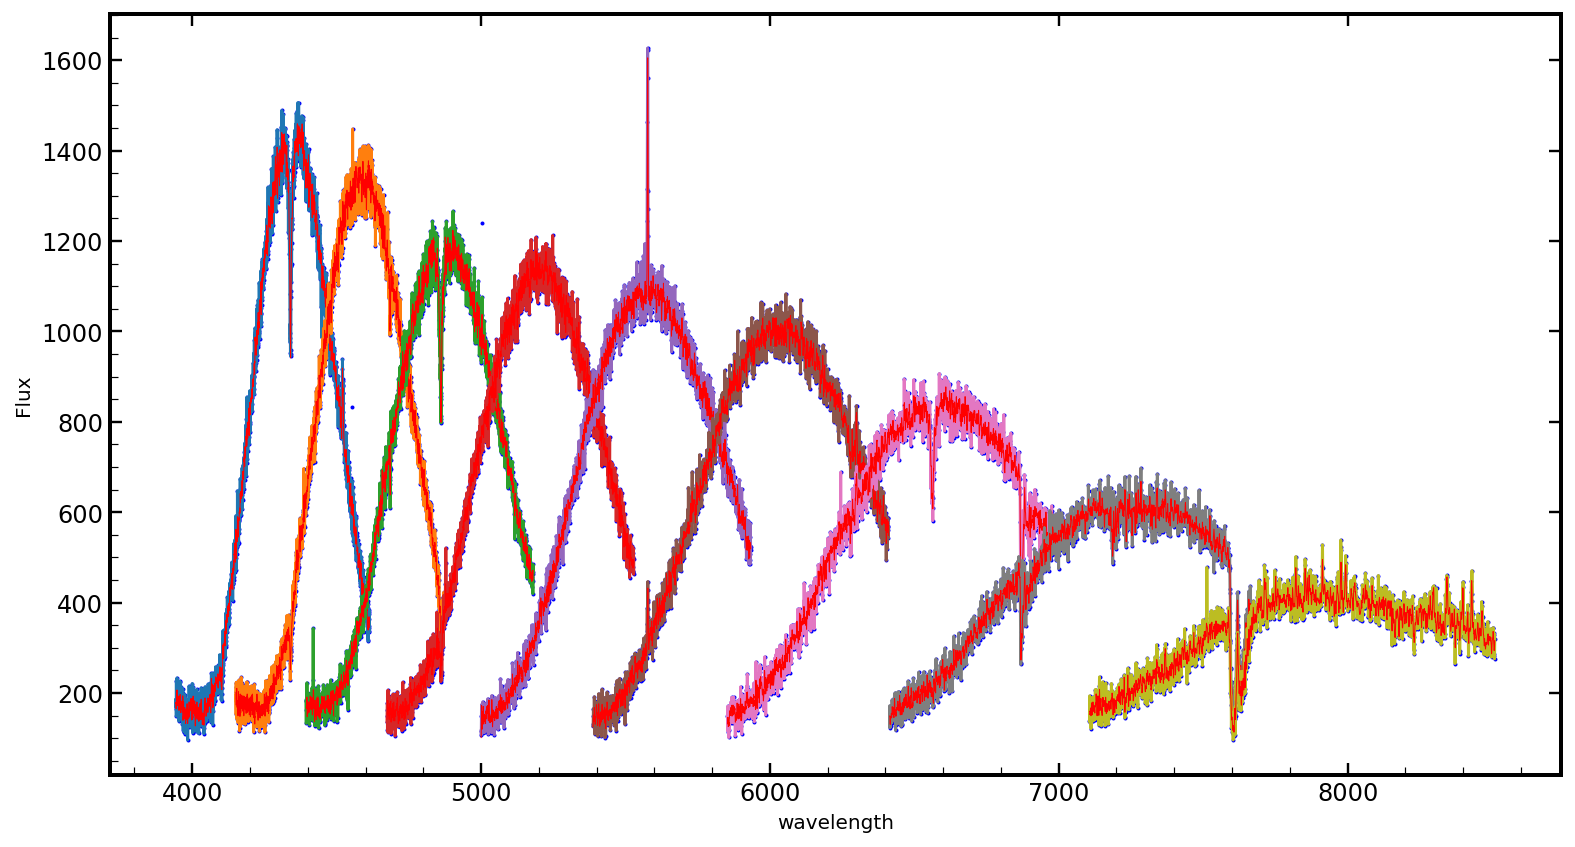

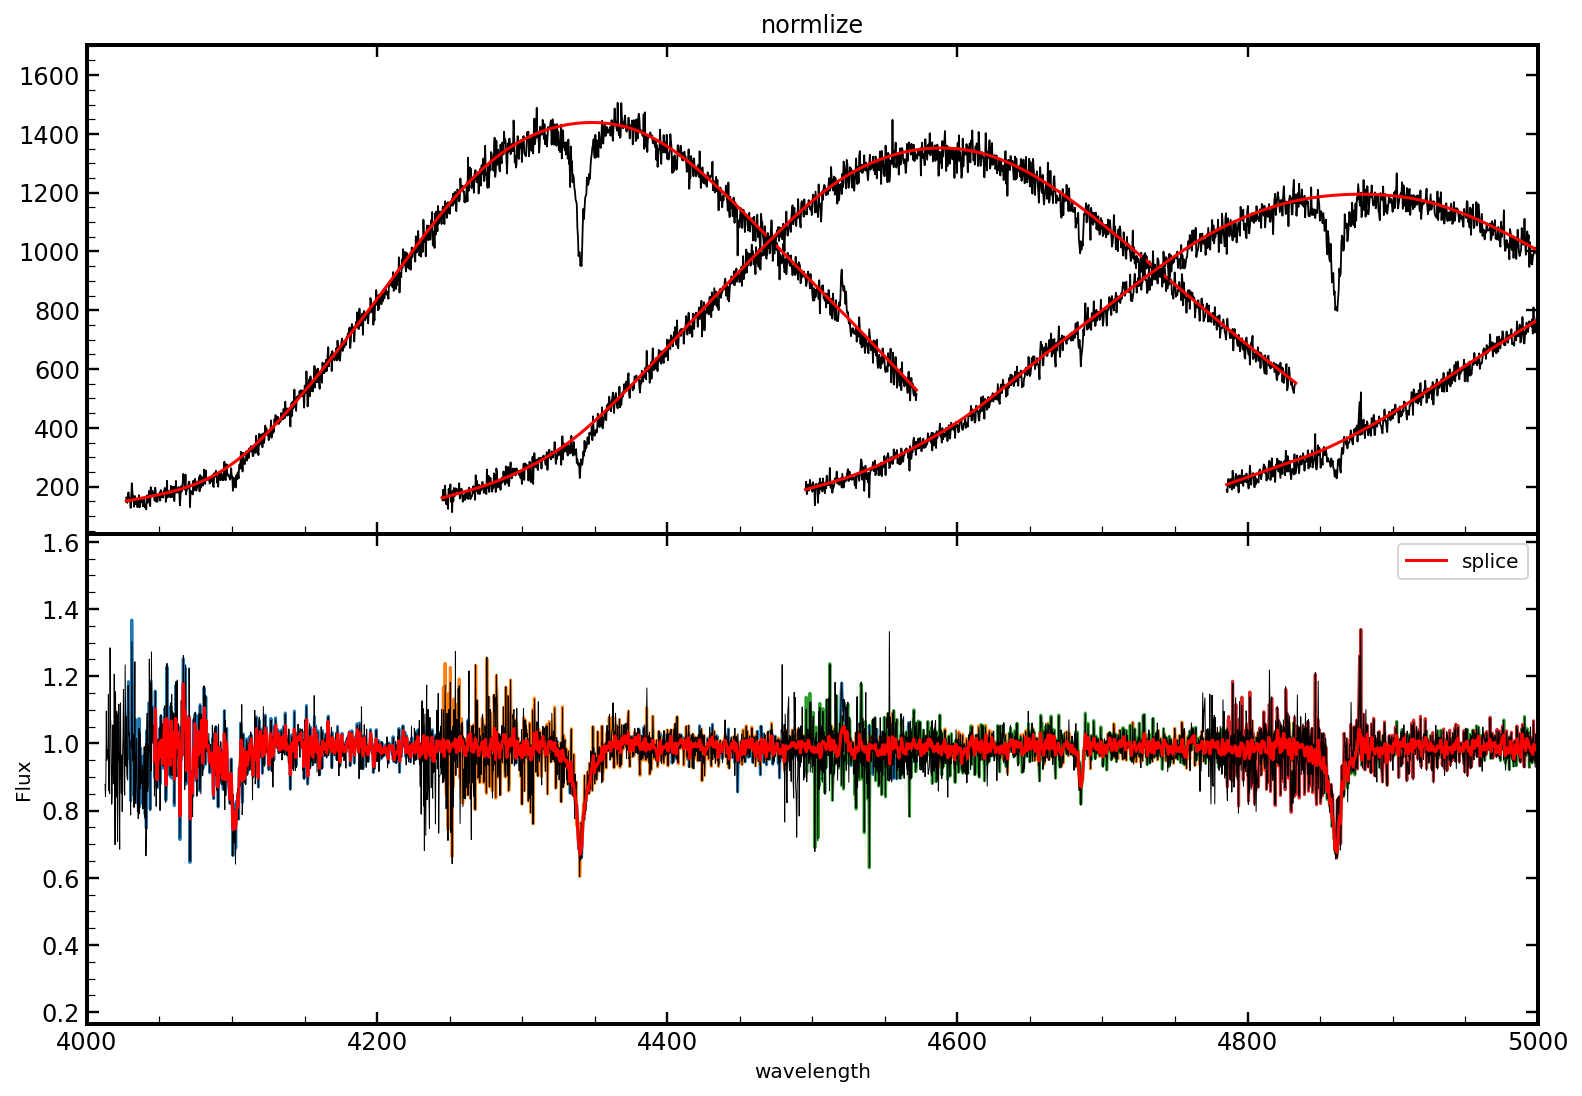

In [60]:
def funcnorm(wave, flux, show=False):
    flux_norm, flux_smoothed =lanorm.normalize_spectrum_spline(wave, flux, p=1E-5, q=0.5, lu=(-1, 3), binwidth=150, niter=5)
    if show:
       plt.plot(wave, flux)
       plt.plot(wave, flux_smoothed)
    return flux_norm, flux_smoothed

fig, ax = plt.subplots(1,1, figsize=[13,7])
#fig2, ax2 = plt.subplots(1,1, figsize=[13,7])
### orders = np.arange(0, 10) and pix=[300, 2030] of generally observed data
### orders = np.arange(0, 7) and pix=[300, 1900] of observed 20211022, 23, 24
for _i, flamp in enumerate(lamplist[2:3]):
    fstar = starlist[2:3][_i]
    print(flamp, fstar)
    fwave, fflux, starfit, lampfit = bfosce9g10.dumpname(flamp, fstar, dire)
    star = splicing_spectrum.combine_wave_flux(fwave, fflux)
    waves = star['wavelength']['wave_solu']
    fluxs = star['flux']['spec_extr']
    flux_errs = star['flux']['err_extr']
    blaze = star['flux']['blaze']
    logwave, flux, flux_err = splicing_spectrum.splicing_spectrum(fwave, fflux, R=3500, N=3, lam_start=3700, lam_end=8900, 
                                                                  pix=[300, 1900], orders=np.arange(0, 7), funcnorm=funcnorm, 
                                                                   divide_blaze=False, threshold_blaze=700,
                                                                  show=True, ax=ax)
    for _i, wave in enumerate(waves):
        flux_norm, flux_smoothed = funcnorm(wave, fluxs[_i])
        plt.plot(wave[250:1950], flux_norm[250:1950], 'k', lw=0.5)

    
#fig, ax = plt.subplots(1,1, figsize=[13,7])
plt.plot(10**logwave, flux, color='r', label='splice')
plt.legend()
#plt.xlim(3400, 9100)
plt.xlim(4000, 5000)

# $f_{splice} = \frac{\sum{f^{i}}}{\sum{f^{i}_{c}}}$

- page 28 of specnan2014

# $\frac{flux}{blaze}$

202110230016_SPECSLAMP_FeAr_slit16s_G10_E9 202110230019_SPECSTARGET_J22373662+2244135_slit16s_G10_E9


No handles with labels found to put in legend.


(4000.0, 4500.0)

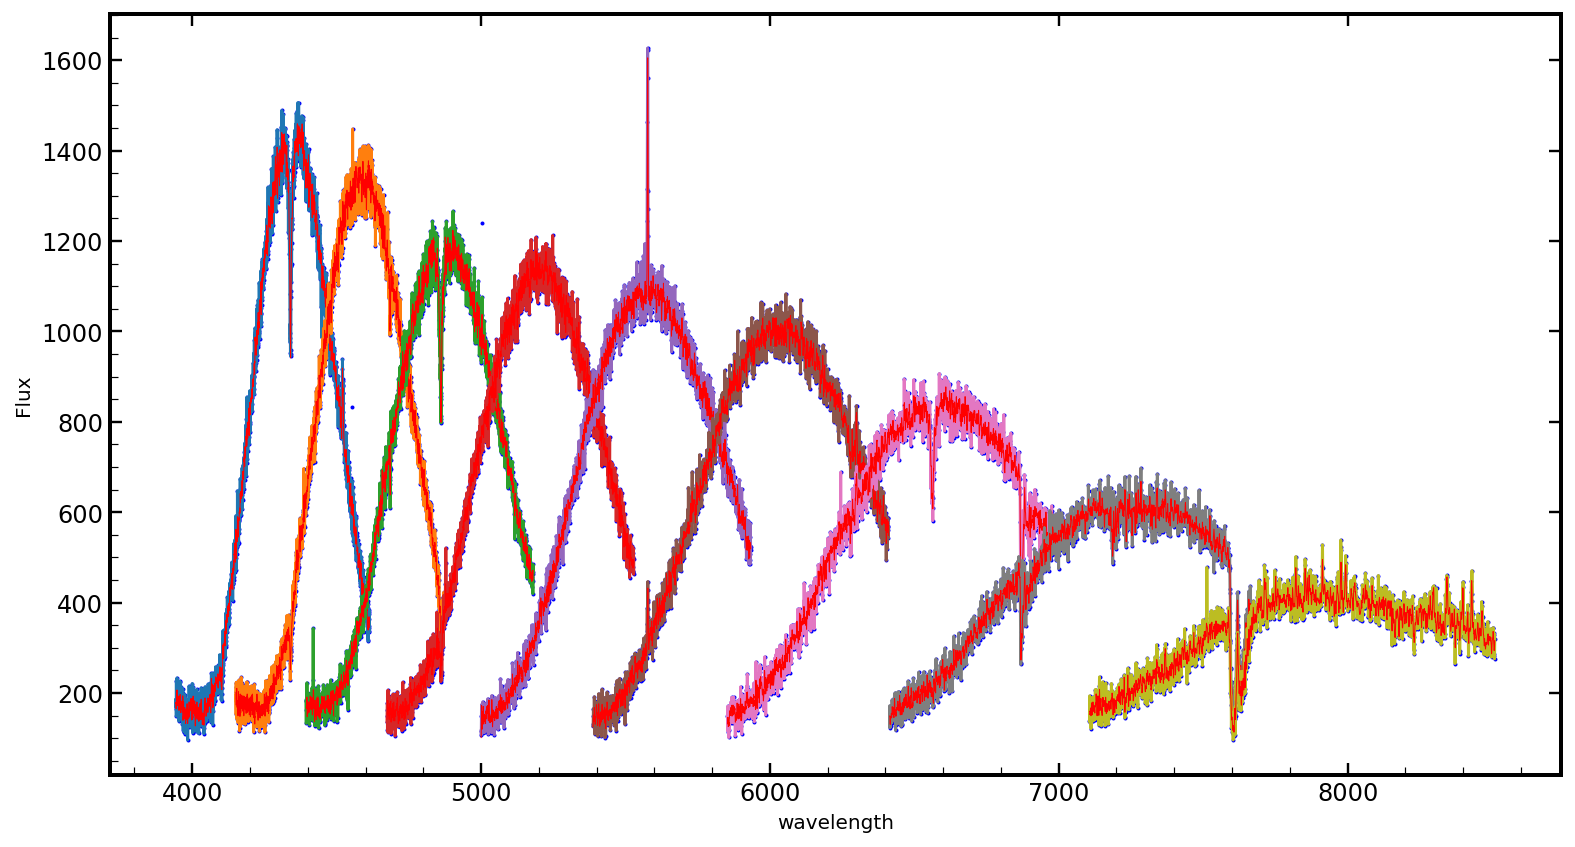

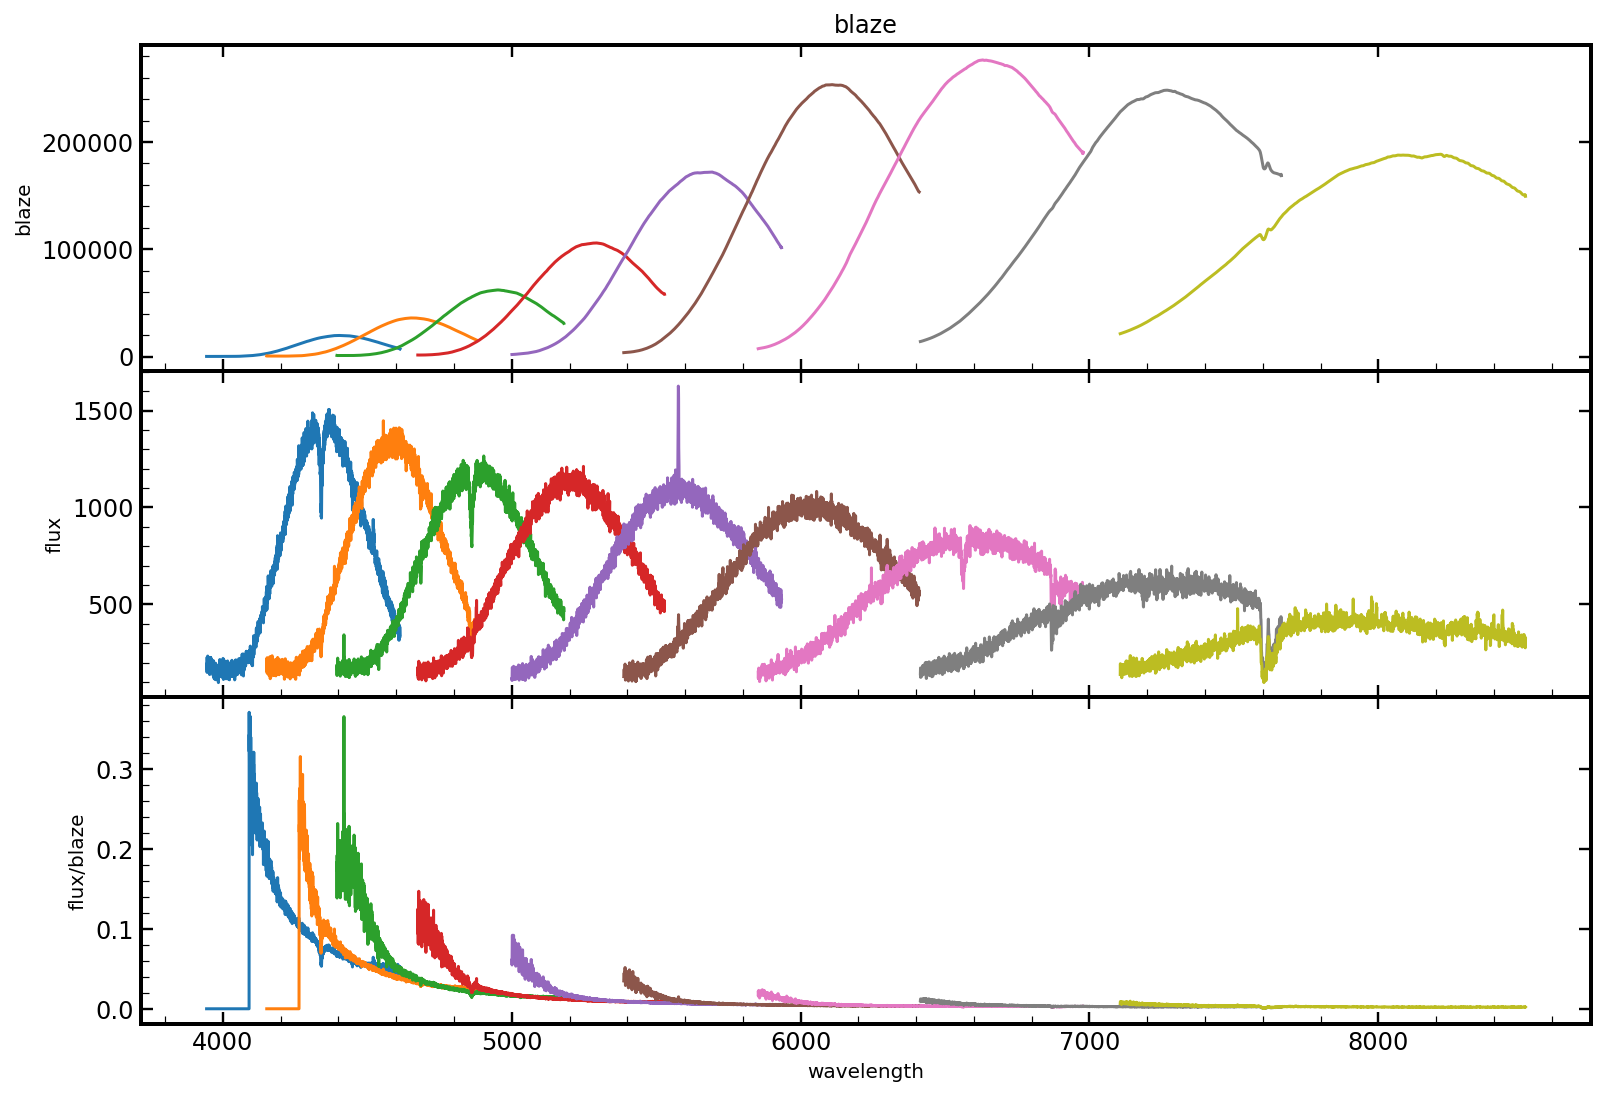

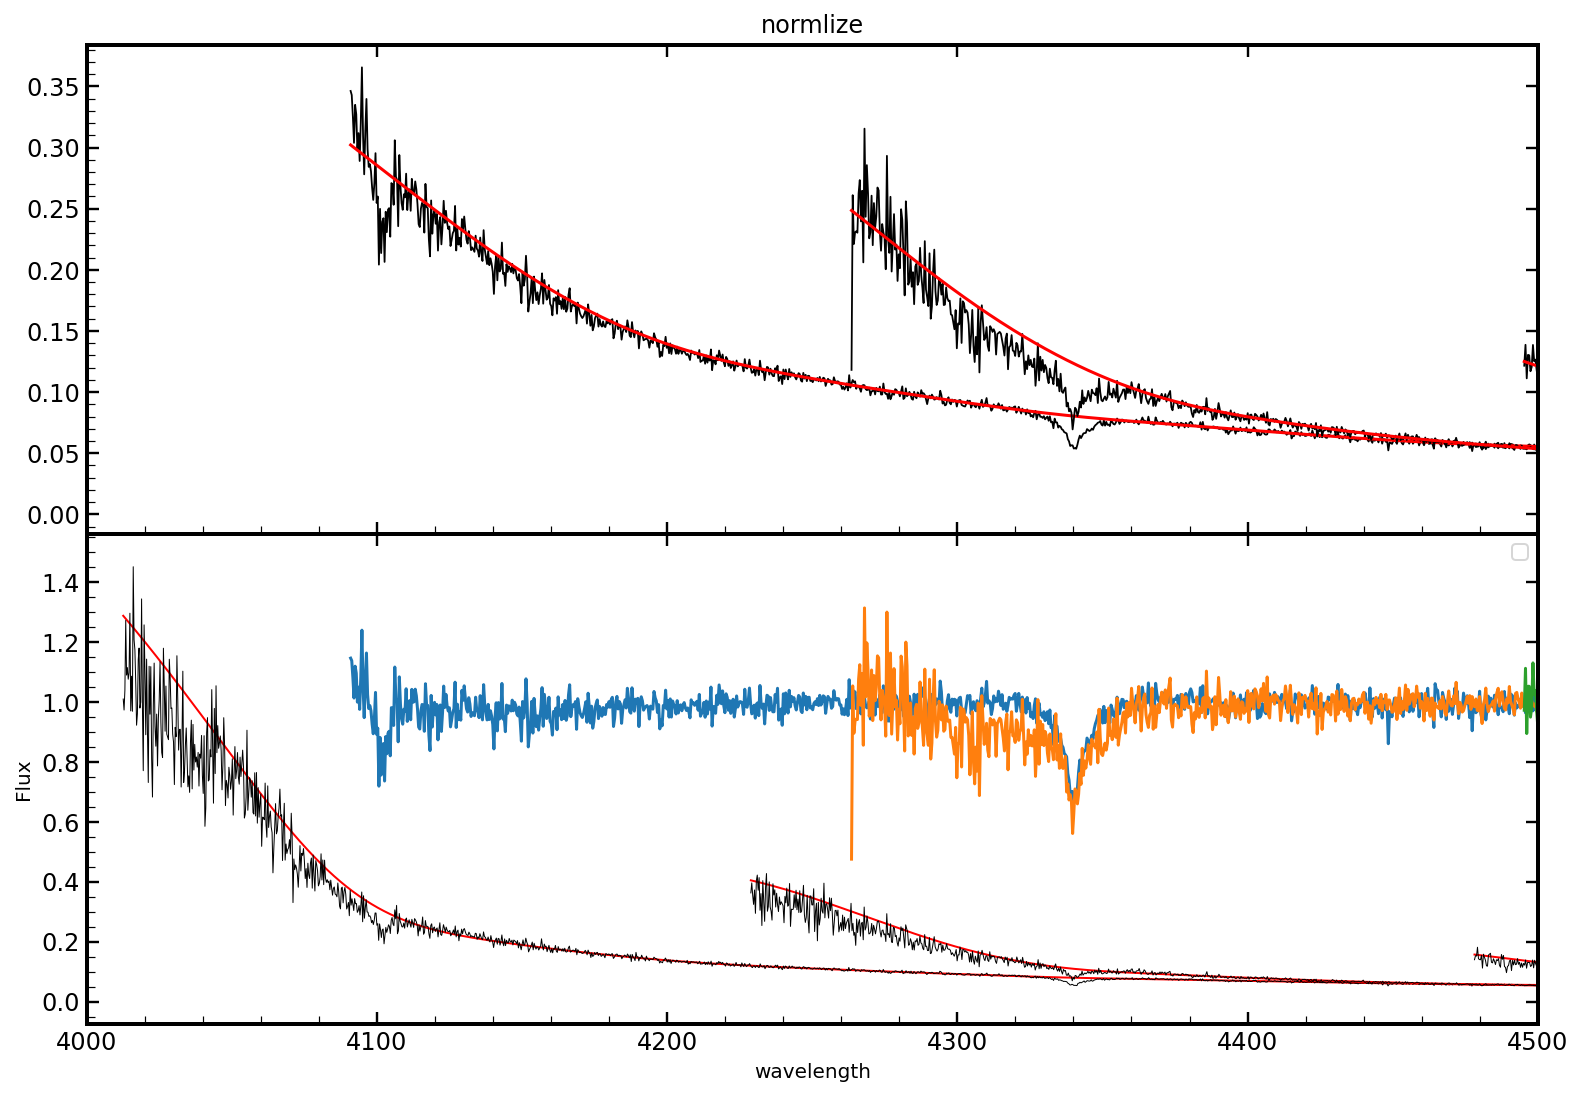

In [62]:
fig, ax = plt.subplots(1,1, figsize=[13,7])
#fig2, ax2 = plt.subplots(1,1, figsize=[13,7])
for _i, flamp in enumerate(lamplist[2:3]):
    fstar = starlist[2:3][_i]
    print(flamp, fstar)
    fwave, fflux, starfit, lampfit = bfosce9g10.dumpname(flamp, fstar, dire)
    star = splicing_spectrum.combine_wave_flux(fwave, fflux)
    waves = star['wavelength']['wave_solu']
    fluxs = star['flux']['spec_extr']
    blaze = star['flux']['blaze']
    flux_errs = star['flux']['err_extr']
    logwave, flux, flux_err = splicing_spectrum.splicing_spectrum(fwave, fflux, R=3500, N=3, lam_start=3700, lam_end=8900, 
                                                                  pix=[300, 1900], orders=np.arange(0, 7), funcnorm=funcnorm, 
                                                                   divide_blaze=True, threshold_blaze=700,
                                                                  show=True, ax=ax)
    for _i, wave in enumerate(waves):
        flux_norm, flux_smoothed = funcnorm(wave, fluxs[_i]/blaze[_i])
        #plt.plot(wave[250:1950], flux_norm[250:1950], 'k', lw=0.5)
        plt.plot(wave[250:1950], flux_smoothed[250:1950], 'r', lw=1)
        plt.plot(wave[250:1950], fluxs[_i][250:1950]/blaze[_i][250:1950], 'k', lw=0.5)

    
#fig, ax = plt.subplots(1,1, figsize=[13,7])
#plt.plot(10**logwave, flux, color='r', label='splice')
plt.legend()
plt.xlim(4000, 4500)
#plt.xlim(6500, 6600)

In [63]:
fitslists = []
for _i, flamp in enumerate(lamplist):
    fstar = starlist[_i]
    print(flamp, fstar)
    fwave, fflux, starfit, lampfit = bfosce9g10.dumpname(flamp, fstar, dire)
    star = splicing_spectrum.combine_wave_flux(fwave, fflux)
    logwave, flux, flux_err = splicing_spectrum.splicing_spectrum(fwave, fflux, R=3000, N=3, lam_start=3700, 
                                                                          lam_end=8900, pix=[300, 2030], orders=np.arange(0, 7), 
                                                                          funcnorm=funcnorm, divide_blaze=False, threshold_blaze=100, ax=ax,
                                                                          sigma =8, percentile_up=99, window_length=11, show=False)
    header = fits.getheader(starfit)
    data0 = np.zeros(1,dtype=np.float32)
    hdu = fits.PrimaryHDU(data0)
    hdu.header = header
    hdu.header['fstar'] = (fstar, 'fname of star raw image')
    hdu.header['flamp'] = (flamp, 'fname of lamp raw image')
    lampdump = joblib.load(fwave)
    hdu.header['rms_lamp'] = (lampdump['rms'], 'r.m.s. of lamp wavelength fitting')
    ##########################################################################################
    jd = header['JD'] + header['EXPOSURE']/2./3600./24.
    ##--------------light_travel_time----------------------------------------------------------
    ##radec is the coordinates of the objects e.g. '04:11:10.73 +50:42:29.60'
    radec = f"{header['RA']} {header['DEC']}"
    ip_peg = coord.SkyCoord(radec, unit=(units.hourangle, units.deg), frame='icrs')
    site = coord.EarthLocation.of_site('Beijing Xinglong Observatory')
    times_ltt = Time(jd, format='jd', scale='utc', location=site)
    ltt = times_ltt.light_travel_time(ip_peg,'barycentric')
    barycorr = ip_peg.radial_velocity_correction(obstime=Time(times_ltt.iso), location=site)
    barycorr = barycorr.to('km/s').value
    #----------------------------------------------------------------------------------------
    header['BJD'] = (jd+ltt.jd, 'Barycentric Julian Date at mean of exposure')
    header['barycorr'] = (barycorr, 'km/s(barycentric rv=rv+barycorr+rv*barycorr/c)')
    # correct wave to barycentric wave
    logwave_bary = rvcorr_spec(10**logwave, flux, flux_err, barycorr, returnwvl=True)
    ###########################################################################################
    table = fits.BinTableHDU.from_columns([
                    fits.Column(name='loglambda',  format='E', array=np.array(logwave, dtype=np.float32)),
                    fits.Column(name='loglambda_bary',  format='E', array=np.array(logwave_bary, dtype=np.float32)),
                    fits.Column(name='flux',format='E', array=np.array(flux, dtype=np.float32)),
                    fits.Column(name='error',format='E', array=np.array(flux_err, dtype=np.float32))
                                         ])
    hdul = fits.HDUList([hdu, table])
    fout = starfit[:-4] +'_splicing.fits'
    hdul.writeto(fout, overwrite=True)
    fitslists.append(fout)

202110230014_SPECSLAMP_FeAr_slit16s_G10_E9 202110230012_SPECSTARGET_BD25d4655_slit16s_G10_E9
202110230016_SPECSLAMP_FeAr_slit16s_G10_E9 202110230018_SPECSTARGET_J22373662+2244135_slit16s_G10_E9
202110230016_SPECSLAMP_FeAr_slit16s_G10_E9 202110230019_SPECSTARGET_J22373662+2244135_slit16s_G10_E9
202110230016_SPECSLAMP_FeAr_slit16s_G10_E9 202110230020_SPECSTARGET_J22373662+2244135_slit16s_G10_E9
202110230025_SPECSLAMP_FeAr_slit16s_G10_E9 202110230022_SPECSTARGET_J22100271+2503582_slit16s_G10_E9
202110230025_SPECSLAMP_FeAr_slit16s_G10_E9 202110230023_SPECSTARGET_J22100271+2503582_slit16s_G10_E9
202110230027_SPECSLAMP_FeAr_slit16s_G10_E9 202110230029_SPECSTARGET_J2255581+3343117_slit16s_G10_E9
202110230027_SPECSLAMP_FeAr_slit16s_G10_E9 202110230030_SPECSTARGET_J2255581+3343117_slit16s_G10_E9
202110230037_SPECSLAMP_FeAr_slit16s_G10_E9 202110230032_SPECSTARGET_J01362619+1139322_slit16s_G10_E9
202110230037_SPECSLAMP_FeAr_slit16s_G10_E9 202110230033_SPECSTARGET_J01362619+1139322_slit16s_G10_E9


# correct wavelength with a velocity

$ln(\frac{\lambda}{\lambda_{0}}) = ln(\sqrt{\frac{1+v/c}{1-v/c}})$

# check the spectra of the day

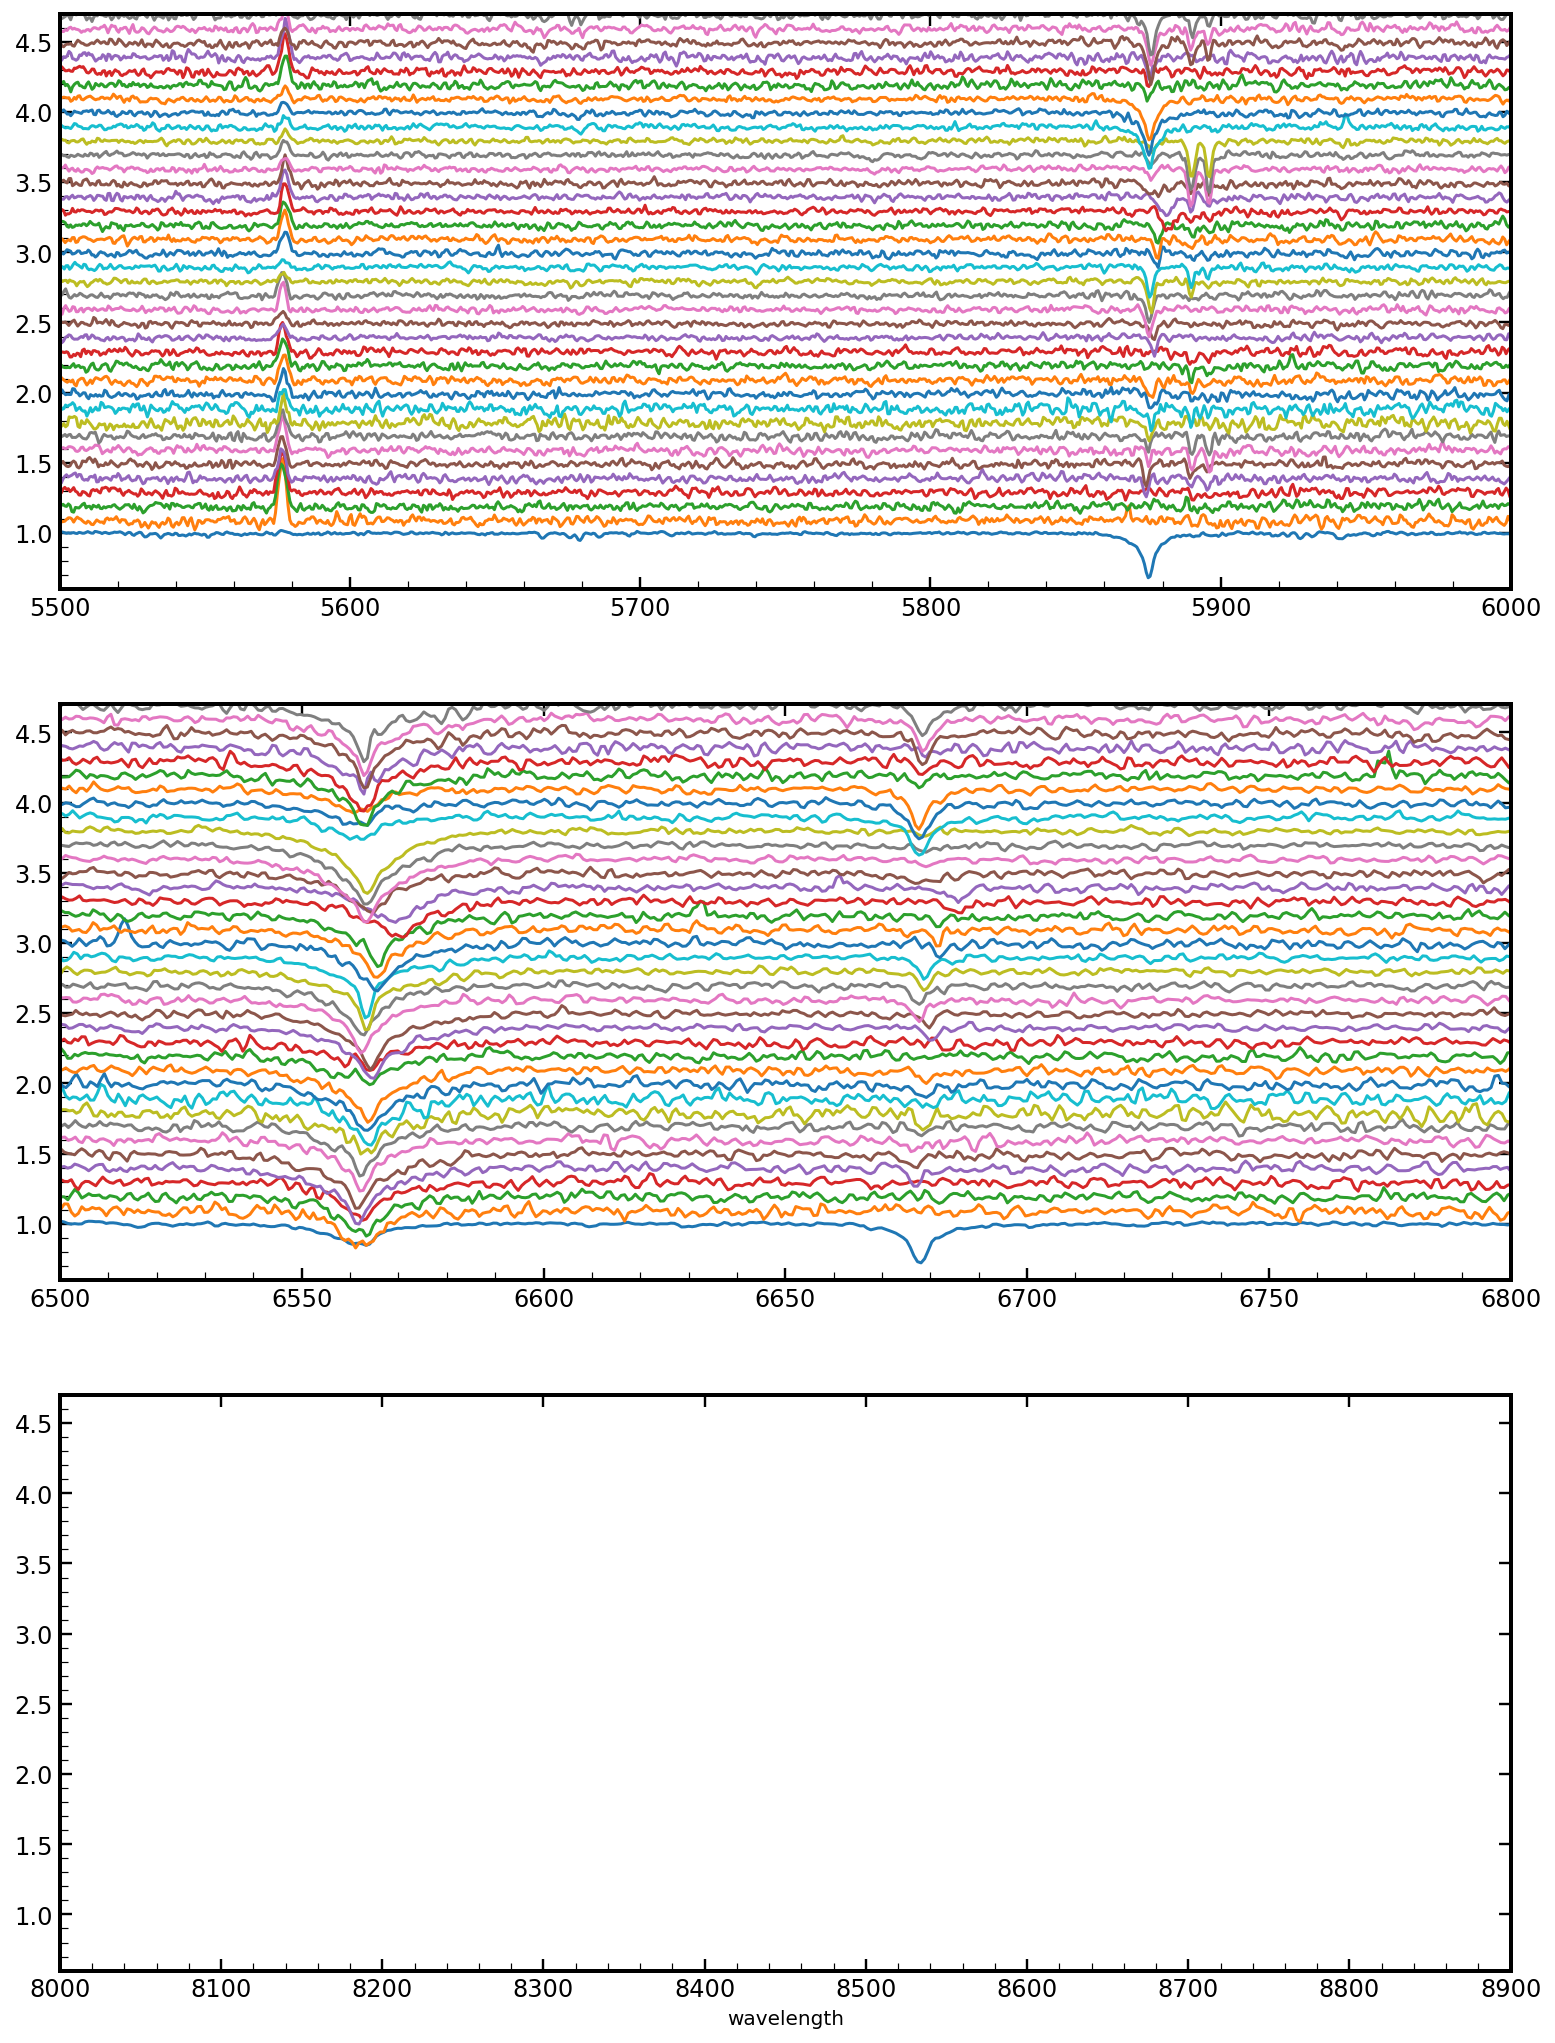

In [83]:
fig, axs = plt.subplots(3,1, figsize=[13,18])
plt.sca(axs[0])
plt.xlim([5500, 6000])
plt.ylim([0.6, 4.7])
plt.sca(axs[1])
plt.xlim([6500, 6800])
plt.ylim([0.6, 4.7])
plt.sca(axs[2])
plt.xlim([8000, 8900])
plt.ylim([0.6, 4.7])
plt.xlabel('wavelength')
for _i, fname in enumerate(fitslists):
    data = fits.getdata(fname, 1)
    wave = 10**data['loglambda_bary']
    flux = data['flux']
    plt.sca(axs[0])
    plt.plot(wave, flux+_i*0.1, )
    plt.sca(axs[1])
    plt.plot(wave, flux+_i*0.1)
    plt.sca(axs[2])
    plt.plot(wave, flux+_i*0.1)

- `coadd`

Page 127: 4.2.6. TheMLE Applied to a Heteroscedastic Gaussian Likelihood

- $\mu^0 = \frac{ \sum_l^N \omega_{l}x_{l}}{\sum_l^N \omega_{l}}$

- $\sigma_{\mu} = \left( \sum_l^N\frac{1}{\sigma_l^2} \right)^{-1/2} = \left( \sum_l^N\omega_l \right)^{-1/2}$

# check lamp

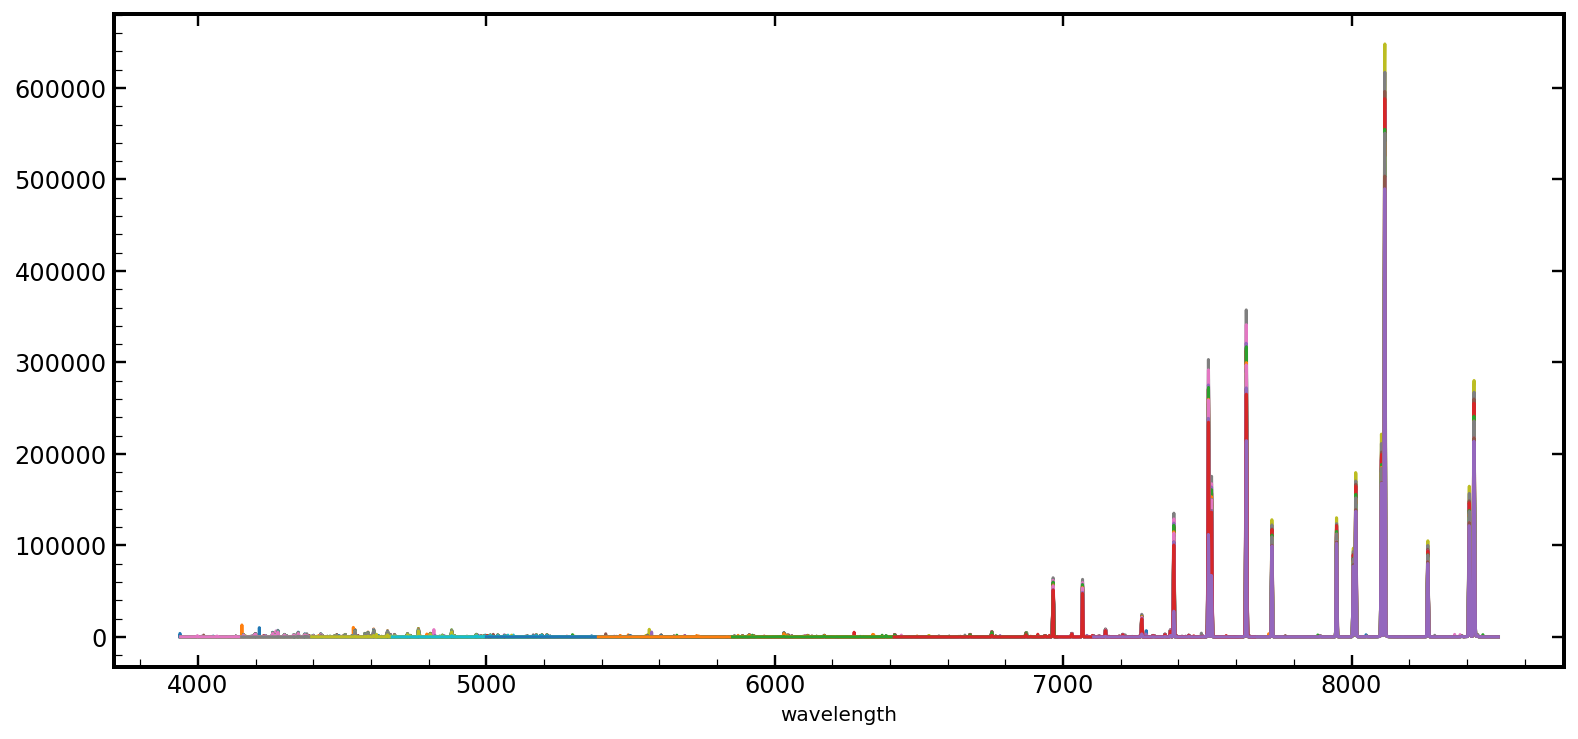

In [65]:
fig, ax = plt.subplots(1,1, figsize=(13,6),sharex=True)
plt.xlabel('wavelength')
for _lampname in np.unique(lamplist):
    _lampname = f'{dire}/fear-{_lampname}.fit.dump'
    lampdata = joblib.load(_lampname)
    plt.plot(lampdata['wave_solu'].T, lampdata['fear1d'].T)

# measuring the radial velcotiy

- (1) using CCF (cross corelation function) code of Zhang Bo
-- RVM is stored in the directory of R730: /share/data/lijiao/216sdB/tlusty_for_bfosc_sdB_rv.dump


@RVM: initializing Radial Velocity Machine (RVM)...
@RVM: calculating local variance ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   22.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   24.1s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   25.7s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   26.6s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   28.1s finished


(6500.0, 6700.0)

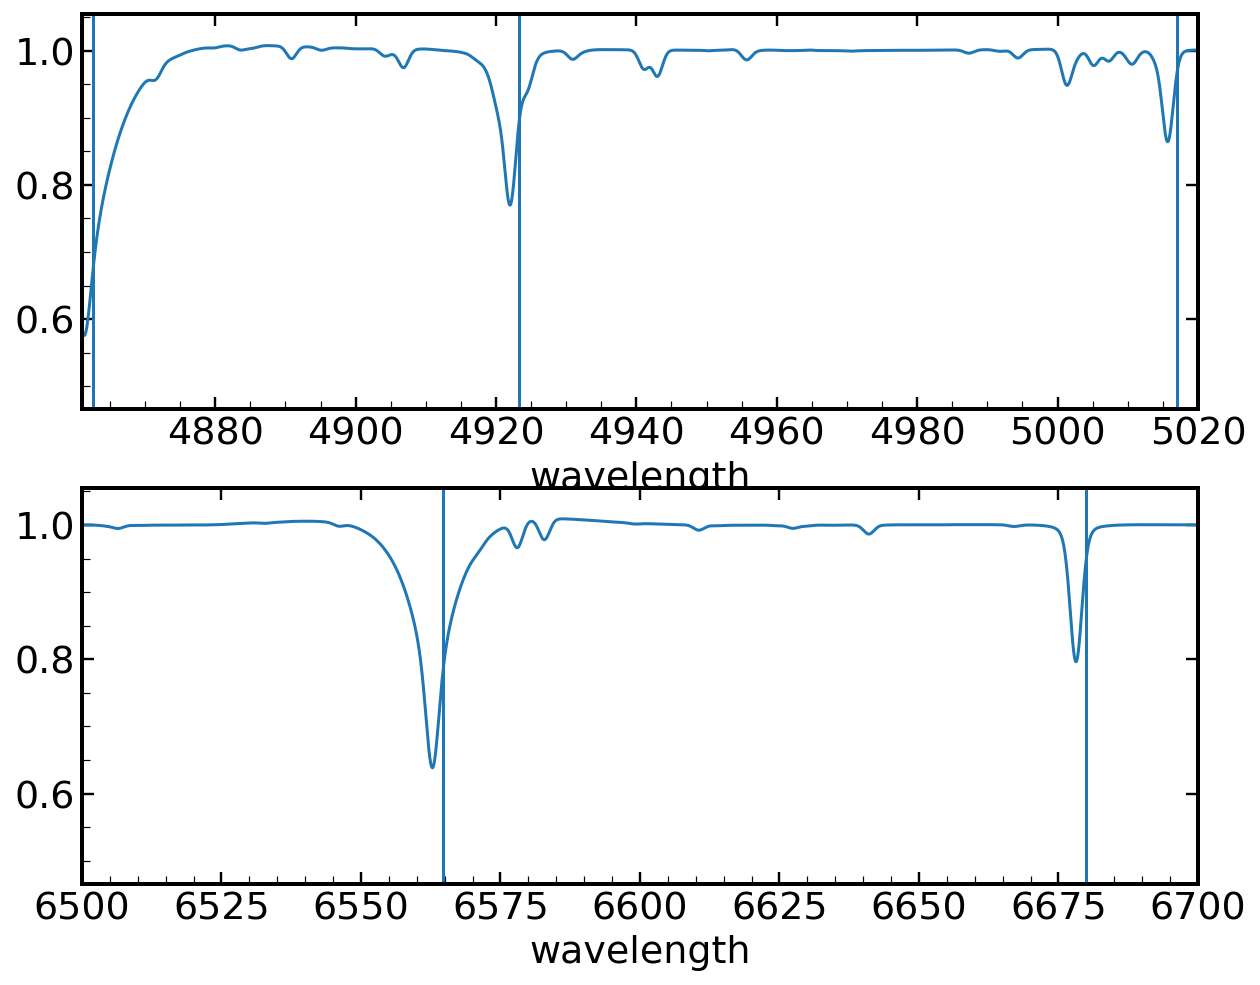

In [12]:
# laod and check radial velocity model
rvm = joblib.load('/media/share/lijiao/TLUSTY_grid/tlusty_for_bfosc_sdB_rv.dump')
from laspec.ccf import RVM
_ind = (rvm.pmod[:,0] >= 27000) & (rvm.pmod[:,0] <= 31000)
pmod_rv = rvm.pmod[_ind]
wavemod_rv = rvm.wave_mod
fluxmod_rv = rvm.flux_mod[_ind]
rvm = RVM(pmod_rv, wavemod_rv, fluxmod_rv, npix_lv=5)

### check rvm model wave is in vacuum or air
haVac = 6564.66464 # vacuum wavelength of Halpha
haAir = 6562.85175
heIAir = 6678.151
heIVac = 6679.995 # vacuum wavelength of HI
fig, axs = plt.subplots(2,1,figsize=[10,8])
plt.sca(axs[0])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=4862.6) #vacum
plt.axvline(x=4923.3)#vacuum
plt.axvline(x=5017.07)#vacuum
plt.xlabel('wavelength')
plt.xlim(4861, 5020)

plt.sca(axs[1])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=haVac)
plt.axvline(x=heIVac)
plt.xlabel('wavelength')
plt.xlim(6500, 6700)

- - select wavelength range for measuring radial velocity by CCF

rvm.pmod: Teff =27000.0; logg = 4.25; Z/Zsun= 1.0; v_mic = 10.0; vsini= 0.0
202110230018_SPECSTARGET_J22373662+2244135_slit16s_G10_E9_splicing.fits


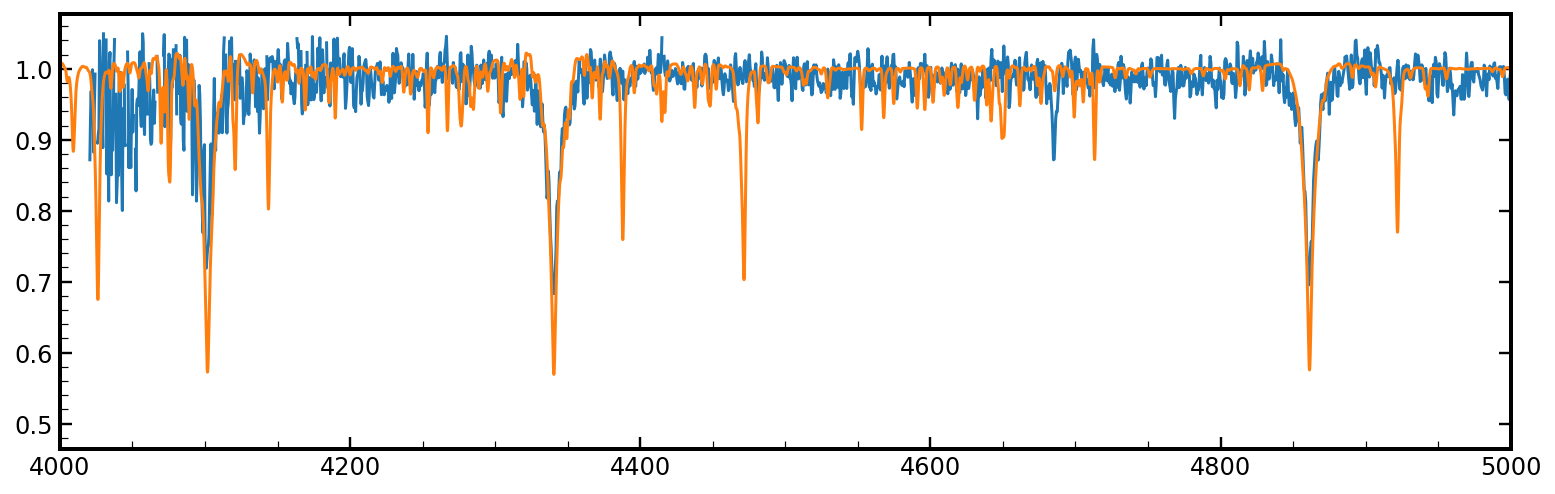

In [81]:
fout = fitslists[1]
hdul = fits.open(fout)
wave = 10**hdul[1].data['loglambda']
flux = hdul[1].data['flux'].copy()
flux_err = hdul[1].data['error'].copy()
hdul.close()


def getrvind(wave):
    ind = ~( (flux > 1.05) |
        (flux < 0.) |
        (wave < 3940) |
        #((wave >5881) & (wave < 6300))|
        ((wave > 6800) & (wave < 7000)) |
        ((wave > 6600) & (wave < 6640))|
        (wave > 7100) |
        np.isnan(flux)
       ) 
    return ind

ind = getrvind(wave)

flux[~ind] = np.nan

_ind = 0
print('rvm.pmod: Teff ={}; logg = {}; Z/Zsun= {}; v_mic = {}; vsini= {}'.format(*rvm.pmod[_ind]))
fig, ax = plt.subplots(1,1, figsize=[13,4])
plt.plot(wave, flux)
plt.plot(rvm.wave_mod, rvm.flux_mod[_ind])
#plt.xlim(6100, 6800)
plt.axvline(x=6563)
plt.axvline(x=6678)
plt.xlim(4000, 5000)
#plt.xlim(7000, 7400)
print(os.path.basename(fout))

- - sersic fit

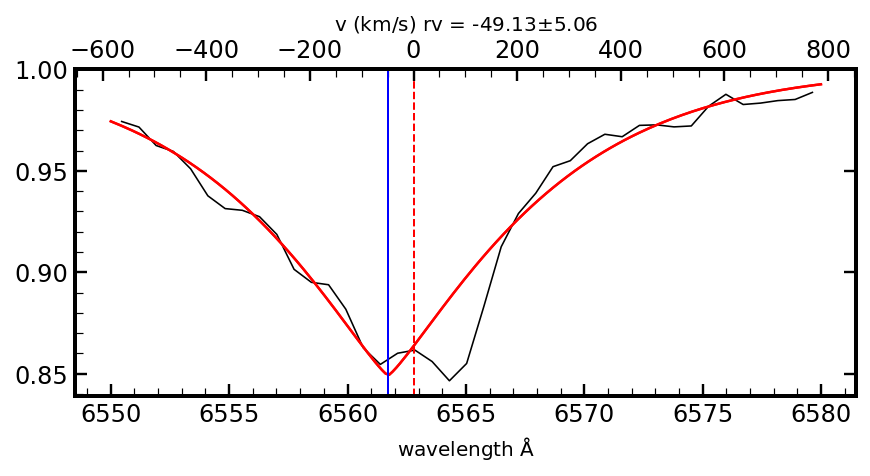

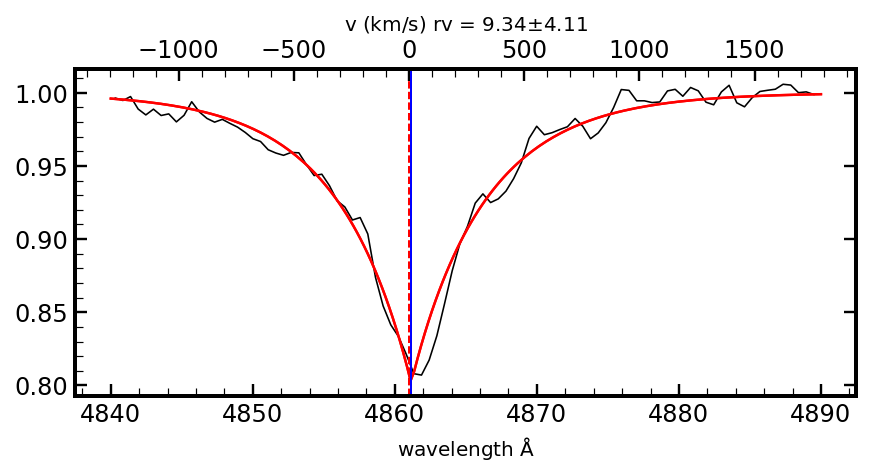

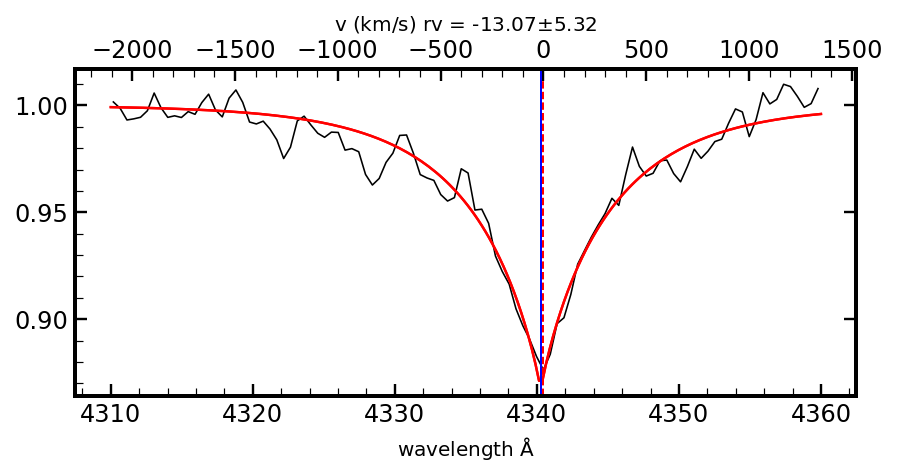

In [67]:
from pyrafspec.RVsersic import *
data = fits.getdata(fitslists[0], 1)
flux = data['flux']
wavebary = 10**data['loglambda_bary']
rv_halpha, rverr_halpha = rv_bysersic(wave, flux, lam0 = 6562.79, waverange = [6550, 6580], p0 = [0.8,4.,1.,6562.], show=True) 
#rv_halpha, rverr_halpha = rv_bysersic(wave, flux, lam0 = 6562.79, waverange = [6550, 6580], p0 = [0.8,4.,1.,6562.], show=True, v=40) 
rv_hbeta, rverr_hbeta = rv_bysersic(wave, flux, lam0=4861, waverange=[4840, 4890], p0=[0.6,4.5,0.8,4862.], show=True)
#rv_hbeta, rverr_hbeta = rv_bysersic(wave, flux, lam0=4861, waverange=[4840, 4890], p0=[0.6,4.5,0.8,4862.], show=True, v=40)
rv_hgamma, rverr_hgamma = rv_bysersic(wave, flux, lam0=4340.46, waverange = [4310, 4360], p0 = [0.8,4.,1.,4340.], show=True)
#rv_hgamma, rverr_hgamma = rv_bysersic(wave, flux, lam0=4340.46, waverange = [4310, 4360], p0 = [0.8,4.,1.,4340.], show=True, v=40)

- - measure radial velocity

In [68]:
def get_rvs(fname, verbose=True, show=False):
    hdul = fits.open(fname)
    header = hdul[0].header
    data = hdul[1].data
    data0 = np.zeros(1,dtype=np.float32)
    flamp = header['FLAMP']
    rms_lamp = header['RMS_LAMP']
    #wave = 10**data['loglambda']
    wave = 10**data['loglambda_bary']
    flux = data['flux']
    fluxerr = data['error']
    barycorr = header['BARYCORR']
    ra = header['RA']
    dec = header['DEC']
    bjd = header['bjd']
    radec = f"{header['RA']} {header['DEC']}"
    ip_peg = coord.SkyCoord(radec, unit=(units.hourangle, units.deg), frame='icrs')
    ra_deg = np.float32(ip_peg.ra.deg)
    dec_deg = np.float32(ip_peg.dec.deg)
    ########------------CCF rv-------------------------------------------########################
    ind = getrvind(wave)
    indbary = getrvind(wavebary)
    wave_obs, flux_obs, fluxerr_obs = wave[ind],  flux[ind], fluxerr[ind]
    rvr = rvm.measure(wave_obs, flux_obs, flux_err=fluxerr_obs, nmc=100, rv_grid=np.arange(-500, 500, 5),
                        )
    rv_ccf = np.float32(rvr['rv_opt'])
    err_ccf = np.float32(np.sqrt(np.sum(np.diff(rvr['rv_pct'])**2)/2))
    basename = os.path.basename(fname)
    if verbose: print(f'{basename}:\nccf baryrv = {rv_ccf}\pm {err_ccf}')
    hdul[0].header['rv_ccf'] = (rv_ccf, '(km/s) barycentric ccf rv')
    hdul[0].header['rverr_ccf'] = (err_ccf, 'radial velocity error(km/s)' )
    ########------------SERSIC rv-------------------------------------------########################
    rv_halpha,rverr_halpha = rv_bysersic(wave, flux, lam0 = 6562.79, waverange = [6550, 6580], p0 = [0.8,4.,1.,6562.], show=show)
    rv_halpha,rverr_halpha = np.float32(rv_halpha), np.float32(rverr_halpha)
    rv_hbeta, rverr_hbeta = rv_bysersic(wave, flux, lam0=4861, waverange=[4840, 4890], p0=[0.6,4.5,0.8,4862.], show=show)
    rv_hbeta,rverr_hbeta = np.float32(rv_hbeta), np.float32(rverr_hbeta)
    rv_hgamma,rverr_hgamma = rv_bysersic(wave, flux, lam0=4340.46, waverange = [4310, 4360], p0 = [0.8,4.,1.,4340.], show=show)
    rv_hgamma,rverr_hgamma = np.float32(rv_hgamma), np.float32(rverr_hgamma)
    if verbose: print(f'sersic fitting baryrv: Halpha = {rv_halpha}\pm{rverr_halpha}')
    if verbose: print(f'sersic fitting baryrv: Hbeta={rv_hbeta}\pm{rverr_hgamma}')
    if verbose: print(f'sersic fitting baryrv: Hgamma={rv_hgamma}\pm{rverr_hgamma}')
    hdul[0].header['rv_ha'] = (rv_halpha, '(km/s) barycentric Halpha rv')
    hdul[0].header['rverr_ha'] = (rverr_halpha, '(km/s) barycentric Halpha rv err')
    hdul[0].header['rv_hb'] = (rv_hbeta, '(km/s) barycentric Hbeta rv')
    hdul[0].header['rverr_hb'] = (rverr_hbeta, '(km/s) barycentric Hbeta rv err')
    hdul[0].header['rv_hg'] = (rv_hgamma, '(km/s) barycentric Hgamma rv')
    hdul[0].header['rverr_hg'] = (rverr_hgamma, '(km/s) barycentric Hgamma rv err')
    ###########################################################################################
    hdul.writeto(_fname, overwrite=True)
    _line = basename,bjd,ra,dec,ra_deg,dec_deg,flamp,rms_lamp,rv_ccf,err_ccf,rv_halpha,rverr_halpha,rv_hbeta,rverr_hbeta,rv_hgamma,rverr_hgamma
    _line = ','.join(list(np.array(_line)))
    _line = _line+'\n'
    return _line


lines = 'basename,bjd,ra,dec,ra_deg,dec_deg,flamp,rms_lamp,rv_ccf,err_ccf,rv_halpha,rverr_halpha,rv_hbeta,rverr_hbeta,rv_hgamma,rverr_hgamma\n'
for _i, _fname in enumerate(tqdm(fitslists)):
    lines += get_rvs(_fname, verbose=False, show=False)


#tabname =  os.path.join(dire, 'rv_tab.csv')
#with open(tabname, 'w') as ff:
#    ff.writelines(lines)
#ff.close()

100%|██████████| 38/38 [02:51<00:00,  4.52s/it]


In [69]:
tabname =  os.path.join(dire, 'rv_tab.csv')
with open(tabname, 'w') as ff:
    ff.writelines(lines)
ff.close()

In [70]:
from astropy.table import Table
tab_rv = Table.read(tabname)
tab_rv

<Table length=38>
                                basename                                ...
                                 str71                                  ...
----------------------------------------------------------------------- ...
        202110230012_SPECSTARGET_BD25d4655_slit16s_G10_E9_splicing.fits ...
202110230018_SPECSTARGET_J22373662+2244135_slit16s_G10_E9_splicing.fits ...
202110230019_SPECSTARGET_J22373662+2244135_slit16s_G10_E9_splicing.fits ...
202110230020_SPECSTARGET_J22373662+2244135_slit16s_G10_E9_splicing.fits ...
202110230022_SPECSTARGET_J22100271+2503582_slit16s_G10_E9_splicing.fits ...
202110230023_SPECSTARGET_J22100271+2503582_slit16s_G10_E9_splicing.fits ...
 202110230029_SPECSTARGET_J2255581+3343117_slit16s_G10_E9_splicing.fits ...
 202110230030_SPECSTARGET_J2255581+3343117_slit16s_G10_E9_splicing.fits ...
202110230032_SPECSTARGET_J01362619+1139322_slit16s_G10_E9_splicing.fits ...
202110230033_SPECSTARGET_J01362619+1139322_slit16s_G10_E9_splicing.fits ...
                                                                    ... ...
202110230075_SPECSTARGET_J07072872+0535578_slit16s_G10_E9_splicing.fits ...
 202110230077_SPECSTARGET_J07142987+216593_slit16s_G10_E9_splicing.fits ...
 202110230078_SPECSTARGET_J07142987+216593_slit16s_G10_E9_splicing.fits ...
 202110230079_SPECSTARGET_J07142987+216593_slit16s_G10_E9_splicing.fits ...
202110230085_SPECSTARGET_J07120240+1133324_slit16s_G10_E9_splicing.fits ...
202110230086_SPECSTARGET_J07120240+1133324_slit16s_G10_E9_splicing.fits ...
202110230087_SPECSTARGET_J07120240+1133324_slit16s_G10_E9_splicing.fits ...
202110230089_SPECSTARGET_J06580212+3630197_slit16s_G10_E9_splicing.fits ...
202110230090_SPECSTARGET_J06580212+3630197_slit16s_G10_E9_splicing.fits ...
202110230091_SPECSTARGET_J06580212+3630197_slit16s_G10_E9_splicing.fits ...

In [71]:
ind = tab_rv['dec'] == '+33:03:34.20'
tab_rv[ind]['bjd']

<Column name='bjd' dtype='float64' length=3>
2459511.245984415
2459511.255337137
2459511.264689859

In [78]:
tab_rv[ind]

<Table length=3>
                                basename                                ...
                                 str71                                  ...
----------------------------------------------------------------------- ...
202110230065_SPECSTARGET_J06532432+3303342_slit16s_G10_E9_splicing.fits ...
202110230066_SPECSTARGET_J06532432+3303342_slit16s_G10_E9_splicing.fits ...
202110230067_SPECSTARGET_J06532432+3303342_slit16s_G10_E9_splicing.fits ...

In [76]:
fig, ax = plt.subplot(1,1, figsize=)

23.333333333333332

In [38]:
basenames = tab_rv[ind]['basename']
for _basename in basenames:
    header = fits.getheader(f'{dire}/{_basename}')
    print(header['DATE-OBS'], header['EXPOSURE'])

2021-11-14T20:09:07 700.0
2021-11-14T20:20:55 700.0
2021-11-14T20:32:42 700.0


202111140086_SPECSTARGET_J06532432+3303342_slit16s_G10_E9_splicing.fits:
 ccf rv = 221.23062411652188\pm 14.854735308654702
ccf baryrv = 243.26862528904178
sersic fitting rv: Halpha = 221.23062411652188\pm6.263423635647734
sersic fitting rv: Hbeta=240.32662671019438\pm4.27223408664709
sersic fitting rv: Hgamma=216.3947355494047\pm4.27223408664709
sersic fitting baryrv: Halpha = 243.26862528904178
sersic fitting baryrv: Hbeta = 262.3660306111347
sersic fitting baryrv: Hgamma = 238.43238149374017
202111140087_SPECSTARGET_J06532432+3303342_slit16s_G10_E9_splicing.fits:
 ccf rv = 5.952236559132686\pm 21.074946132752395
ccf baryrv = 27.956698439396856
sersic fitting rv: Halpha = 5.952236559132686\pm5.051731057974733
sersic fitting rv: Hbeta=38.46789971265048\pm3.982822128779489
sersic fitting rv: Hgamma=-2.501006502987223\pm3.982822128779489
sersic fitting baryrv: Halpha = 27.956698439396856
sersic fitting baryrv: Hbeta = 60.47474816217567
sersic fitting baryrv: Hgamma = 19.502834930141894


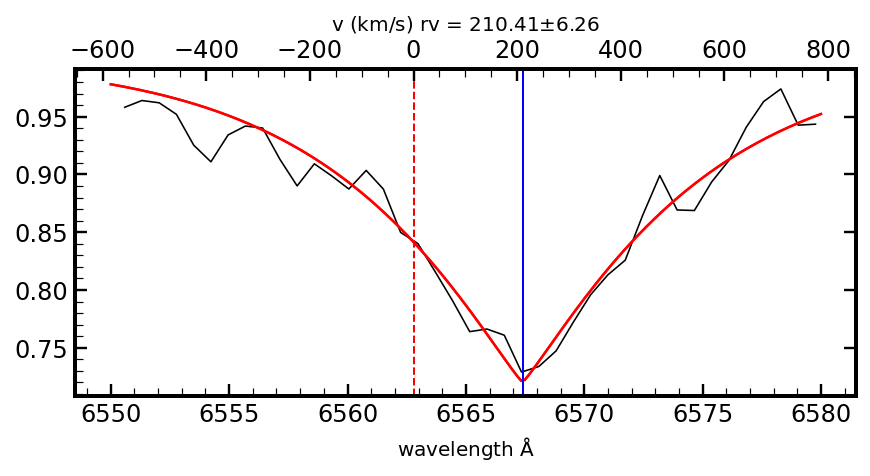

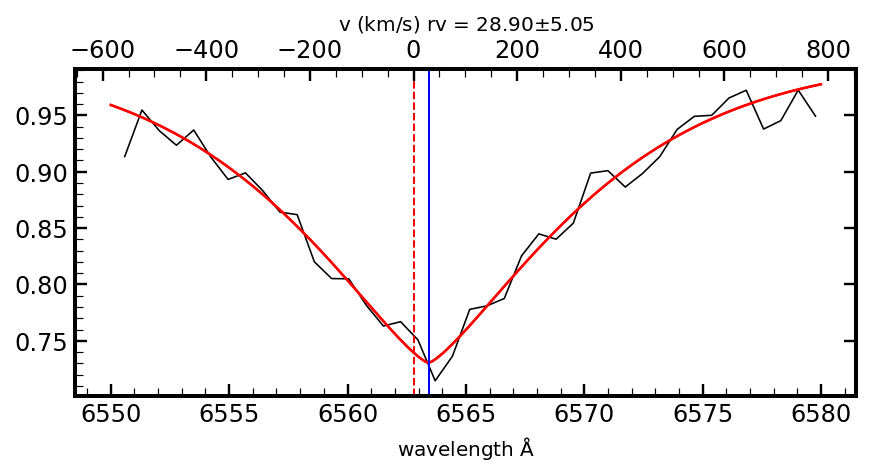

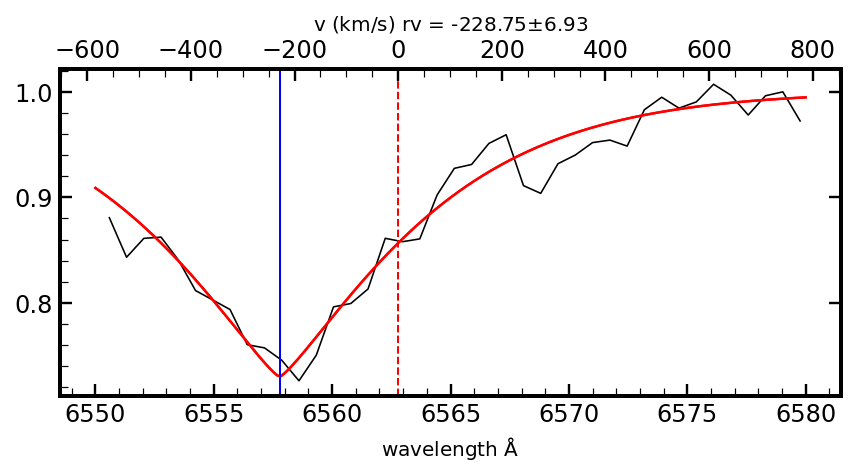

In [47]:
for _i, _fname in enumerate(fitslists[29:32]):
    hdul = fits.open(_fname)
    header = hdul[0].header
    data = hdul[1].data
    data0 = np.zeros(1,dtype=np.float32)
    wave = 10**data['loglambda']
    wavebary = 10**data['loglambda_bary']
    flux = data['flux']
    fluxerr = data['error']
    barycorr = header['BARYCORR']
    ########------------CCF rv-------------------------------------------########################
    ind = getrvind(wave)
    indbary = getrvind(wavebary)
    wave_obs, flux_obs, fluxerr_obs = wave[ind],  flux[ind], fluxerr[ind]
    wavebary_obs, fluxbary_obs, fluxerrbary_obs = wavebary[indbary],  flux[indbary], fluxerr[indbary]
    rvr = rvm.measure(wave_obs, flux_obs, flux_err=fluxerr_obs, nmc=100, rv_grid=np.arange(-500, 500, 5),
                        )
    rv_ccf = rvr['rv_opt']
    rvrbary = rvm.measure(wavebary_obs, fluxbary_obs, flux_err=fluxerrbary_obs, nmc=100, rv_grid=np.arange(-500, 500, 5),
                        )
    rvbary_ccf = rvrbary['rv_opt']
    err_ccf = np.sqrt(np.sum(np.diff(rvr['rv_pct'])**2)/2)
    print(f'{os.path.basename(_fname)}:\n ccf rv = {rv_ccf}\pm {err_ccf}')
    hdul[0].header['rv_ccf'] = (rv_ccf, '(km/s)')
    baryrv_ccf = rv2baryrv(rv_ccf, barycorr)
    hdul[0].header['baryrv_ccf'] = (baryrv_ccf, 'baryrv =rv+BARYCORR(1+rv/c) (km/s)')
    hdul[0].header['rverr_ccf'] = (err_ccf, 'radial velocity error(km/s)' )
    print(f'ccf baryrv = {baryrv_ccf}')
    ########------------SERSIC rv-------------------------------------------########################
    rv_halpha, rverr_halpha = rv_bysersic(wave, flux, lam0 = 6562.79, waverange = [6550, 6580], p0 = [0.8,4.,1.,6562.], show=True)
    rv_hbeta, rverr_hbeta = rv_bysersic(wave, flux, lam0=4861, waverange=[4840, 4890], p0=[0.6,4.5,0.8,4862.], show=False)
    rv_hgamma, rverr_hgamma = rv_bysersic(wave, flux, lam0=4340.46, waverange = [4310, 4360], p0 = [0.8,4.,1.,4340.], show=False)
    rv_halpha = rvr['rv_opt']
    print(f'sersic fitting rv: Halpha = {rv_halpha}\pm{rverr_halpha}')
    print(f'sersic fitting rv: Hbeta={rv_hbeta}\pm{rverr_hgamma}')
    print(f'sersic fitting rv: Hgamma={rv_hgamma}\pm{rverr_hgamma}')
    hdul[0].header['rv_halpha'] = (rv_halpha, '(km/s)')
    hdul[0].header['rverr_halpha'] = (rverr_halpha, '(km/s)')
    hdul[0].header['rv_hbeta'] = (rv_hbeta, '(km/s)')
    hdul[0].header['rverr_hbeta'] = (rverr_hbeta, '(km/s)')
    hdul[0].header['rv_hgamma'] = (rv_hgamma, '(km/s)')
    hdul[0].header['rverr_hgamma'] = (rverr_hgamma, '(km/s)')
    baryrv_halpha = rv2baryrv(rv_halpha, barycorr)
    baryrv_hbeta = rv2baryrv(rv_hbeta, barycorr)
    baryrv_hgamma = rv2baryrv(rv_hgamma, barycorr)
    hdul[0].header['baryrv_halpha'] = (baryrv_halpha, '(km/s)')
    hdul[0].header['baryrv_hbeta'] = (baryrv_hbeta, '(km/s)')
    hdul[0].header['baryrv_hgamma'] = (baryrv_hgamma, '(km/s)')
    print(f'sersic fitting baryrv: Halpha = {baryrv_halpha}')
    print(f'sersic fitting baryrv: Hbeta = {baryrv_hbeta}')
    print(f'sersic fitting baryrv: Hgamma = {baryrv_hgamma}') 
    ###########################################################################################
    
    
    #hdul.writeto(_fname, overwrite=True)
    fitslists.append(fout)